### Construção e Solução de um modelo de Markov

Autor: João Marcos Torres Gardingo

In [86]:
%pip install networkx scipy pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [87]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import numpy as np
import pandas as pd
from scipy.linalg import solve

def generate_system(states, edges):
    state_to_index = {state: index for index, state in enumerate(states)}
    edge_list_index = [(
        state_to_index[src], state_to_index[dst], {'w': data['w']}
    ) for (src, dst, data) in edges]
    
    # Create a square matrix for the system of equations
    size = len(states)
    A = np.zeros((size, size))
    b = np.zeros(size)
    
    # Fill in the matrix A using the edge list
    for (src, dst, data) in edge_list_index:
        A[src][src] -= data['w']  # Subtract weight from the diagonal (outgoing rate)
        A[dst][src] += data['w']  # Add weight to the corresponding row (incoming rate)
    
    # Replace one equation with the conservation of probability
    A[-1] = np.ones(size)
    b[-1] = 1  # The sum of probabilities is equal to 1
    
    return A, b

def my_draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=None,
    label_pos=0.5,
    font_size=10,
    font_color="k",
    font_family="sans-serif",
    font_weight="normal",
    alpha=None,
    bbox=None,
    horizontalalignment="center",
    verticalalignment="center",
    ax=None,
    rotate=True,
    clip_on=True,
    rad=0
):
    """Draw edge labels.

    Parameters
    ----------
    G : graph
        A networkx graph

    pos : dictionary
        A dictionary with nodes as keys and positions as values.
        Positions should be sequences of length 2.

    edge_labels : dictionary (default={})
        Edge labels in a dictionary of labels keyed by edge two-tuple.
        Only labels for the keys in the dictionary are drawn.

    label_pos : float (default=0.5)
        Position of edge label along edge (0=head, 0.5=center, 1=tail)

    font_size : int (default=10)
        Font size for text labels

    font_color : string (default='k' black)
        Font color string

    font_weight : string (default='normal')
        Font weight

    font_family : string (default='sans-serif')
        Font family

    alpha : float or None (default=None)
        The text transparency

    bbox : Matplotlib bbox, optional
        Specify text box properties (e.g. shape, color etc.) for edge labels.
        Default is {boxstyle='round', ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0)}.

    horizontalalignment : string (default='center')
        Horizontal alignment {'center', 'right', 'left'}

    verticalalignment : string (default='center')
        Vertical alignment {'center', 'top', 'bottom', 'baseline', 'center_baseline'}

    ax : Matplotlib Axes object, optional
        Draw the graph in the specified Matplotlib axes.

    rotate : bool (deafult=True)
        Rotate edge labels to lie parallel to edges

    clip_on : bool (default=True)
        Turn on clipping of edge labels at axis boundaries

    Returns
    -------
    dict
        `dict` of labels keyed by edge

    Examples
    --------
    >>> G = nx.dodecahedral_graph()
    >>> edge_labels = nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G))

    Also see the NetworkX drawing examples at
    https://networkx.org/documentation/latest/auto_examples/index.html

    See Also
    --------
    draw
    draw_networkx
    draw_networkx_nodes
    draw_networkx_edges
    draw_networkx_labels
    """
    import matplotlib.pyplot as plt
    import numpy as np

    if ax is None:
        ax = plt.gca()
    if edge_labels is None:
        labels = {(u, v): d for u, v, d in G.edges(data=True)}
    else:
        labels = edge_labels
    text_items = {}
    for (n1, n2), label in labels.items():
        (x1, y1) = pos[n1]
        (x2, y2) = pos[n2]
        (x, y) = (
            x1 * label_pos + x2 * (1.0 - label_pos),
            y1 * label_pos + y2 * (1.0 - label_pos),
        )
        pos_1 = ax.transData.transform(np.array(pos[n1]))
        pos_2 = ax.transData.transform(np.array(pos[n2]))
        linear_mid = 0.5*pos_1 + 0.5*pos_2
        d_pos = pos_2 - pos_1
        rotation_matrix = np.array([(0,1), (-1,0)])
        ctrl_1 = linear_mid + rad*rotation_matrix@d_pos
        ctrl_mid_1 = 0.5*pos_1 + 0.5*ctrl_1
        ctrl_mid_2 = 0.5*pos_2 + 0.5*ctrl_1
        bezier_mid = 0.5*ctrl_mid_1 + 0.5*ctrl_mid_2
        (x, y) = ax.transData.inverted().transform(bezier_mid)

        if rotate:
            # in degrees
            angle = np.arctan2(y2 - y1, x2 - x1) / (2.0 * np.pi) * 360
            # make label orientation "right-side-up"
            if angle > 90:
                angle -= 180
            if angle < -90:
                angle += 180
            # transform data coordinate angle to screen coordinate angle
            xy = np.array((x, y))
            trans_angle = ax.transData.transform_angles(
                np.array((angle,)), xy.reshape((1, 2))
            )[0]
        else:
            trans_angle = 0.0
        # use default box of white with white border
        if bbox is None:
            bbox = dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(1.0, 1.0, 1.0))
        if not isinstance(label, str):
            label = str(label)  # this makes "1" and 1 labeled the same

        t = ax.text(
            x,
            y,
            label,
            size=font_size,
            color=font_color,
            family=font_family,
            weight=font_weight,
            alpha=alpha,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            rotation=trans_angle,
            transform=ax.transData,
            bbox=bbox,
            zorder=1,
            clip_on=clip_on,
        )
        text_items[(n1, n2)] = t

    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )

    return text_items

def filter_duplex_edges(edges):
    # Store edges in a dictionary with the nodes as keys (in a tuple, order matters) and weights as values
    edge_dict = {(src, dst): data['w'] for src, dst, data in edges}
    # Find duplex edges where both (a, b) and (b, a) exist
    duplex_edges = []
    for (src, dst), weight in edge_dict.items():
        if (dst, src) in edge_dict:
            duplex_edges.append((src, dst, {'w': weight}))
    
    duplex_copy = duplex_edges.copy()

    for (src, dst, _) in duplex_copy:
        duplex_copy.remove((dst, src, {'w': edge_dict[(dst, src)]}))
        
    return duplex_copy

def generate_states(N, K):
    # Generate all combinations of N users distributed across K resources
    # Each combination will be a tuple where the sum of the numbers is N
    # and the length of the tuple is K.
    # For example, if N=2 and K=3, one possible state could be (0, 2, 0)
    # which means 0 users in the first resource, 2 in the second, and 0 in the third.
    
    # The states are generated using a product function which considers repetition.
    # This is because each resource can have a number from 0 to N users.
    # The filter is used to ensure that the sum of users in each state is exactly N.
    
    state_list = list(filter(lambda x: sum(x) == N, itertools.product(range(N+1), repeat=K)))
    state_list.reverse()
    return state_list

def generate_states2(N, K, max_users_per_resource):
    """
    Generate all combinations of N users distributed across K resources, with
    each resource having a maximum number of users specified by max_users_per_resource.

    Parameters:
    N (int): Total number of users.
    K (int): Number of resources.
    max_users_per_resource (list): A list containing the maximum number of users for each resource.

    Returns:
    List of tuples representing all possible states.
    """
    
    # Check if max_users_per_resource has K elements
    if len(max_users_per_resource) != K:
        raise ValueError("max_users_per_resource must have K elements.")

    # Generate product with limits for each resource
    ranges = [range(min(N + 1, limit + 1)) for limit in max_users_per_resource]

    # Generate all possible combinations given the individual resource limits
    state_list = [state for state in itertools.product(*ranges) if sum(state) == N]
    state_list.reverse()
    return state_list

def generate_states_birthdeath(M):
    state_list = [i for i in range(0, M + 1)]
    return state_list

def generate_edges_old(states, S):
    """
    Generate a list of edges with weights between the states based on service times S.
    The weights are determined by the number of transactions per minute each resource can complete.
    """
    edge_list = []
    weights = [60 / s for s in S]  # Calculate weights based on service times

    # Map the states to their index in the states list for easy lookup
    state_to_index = {state: index for index, state in enumerate(states)}

    # Define transition probabilities for moving from CPUs to resources and back
    transition_probs = {
        'CPU_to_resource': 1 / (len(S) - 1),  # Assuming equal probability to any resource
        'resource_to_CPU': 1  # Always moving back to CPU
    }

    # Iterate through each state to create edges according to the system rules
    for state in states:
        # Iterate through all possible transitions
        for i in range(len(S)):
            if state[i] > 0:  # There is at least one user in the current resource
                for j in range(len(S)):
                    if i == j:  # Skip if it's the same resource
                        continue
                    
                    # Moving from resource i to resource j (including CPU)
                    if(i != 0 and j != 0):
                        continue
                    else:
                        next_state = list(state)
                        next_state[i] -= 1
                        next_state[j] += 1
                        next_state = tuple(next_state)

                    if next_state in state_to_index:
                        if i == 0:  # Transition from CPU to resource
                            prob = transition_probs['CPU_to_resource']
                        else:  # Transition from resource to CPU
                            prob = transition_probs['resource_to_CPU']
                        weight = weights[i] * prob
                        edge_list.append((state_to_index[state], state_to_index[next_state], {'w': float(f"{weight:.2f}")}))
    edges =  [(states[src], states[dst], attr) for src, dst, attr in edge_list]
    return edges

def generate_edges(N, S, states, transition_probs, transition_type='discrete', factor = 60):
    edge_list = []
    weights = [factor / s if transition_type == 'continuous' else 1 for s in S]  # Calculate weights based on service times

    # Map the states to their index in the states list for easy lookup
    state_to_index = {state: index for index, state in enumerate(states)}

    # Iterate through each state to create edges according to the system rules
    for state in states:
        # Iterate through all possible transitions
        for i in range(len(S)):
            if state[i] > 0:  # There is at least one user in the current resource
                for j in range(len(S)):
                    # Skip if it's the same resource or transition is not allowed
                    if i == j or (i, j) not in transition_probs:
                        continue
                    
                    next_state = list(state)
                    next_state[i] -= 1
                    next_state[j] += 1
                    next_state = tuple(next_state)

                    if next_state in state_to_index:
                        state_has_N = N in state
                        weight = weights[i] * transition_probs[(i, j)] * (N if state_has_N and transition_type == 'discrete' else 1)
                        edge_list.append((state_to_index[state], state_to_index[next_state], {'w': float(f"{weight:.2f}")}))
    edges =  [(states[src], states[dst], attr) for src, dst, attr in edge_list]
    return edges

def generate_edges3(states, service_rates, lambda_system, transition_probs, resources, transition_origins={}):
    edge_list = []
    weights = [(1 / s) for s in service_rates]  # Calculate weights based on service times    
    
    initial_resources = [transition[1] for transition in transition_probs if transition[0] is None]
    initial_states = [state for state in states if state[0] in initial_resources]

    # Arestas de chegada no sistema
    for state in states:
        # Para o estado inicial onde todos os servidores estão livres (representado por zeros)
        
        if state in initial_states:
            # Crie arestas para cada servidor possível com sua respectiva probabilidade
            for i in range(len(service_rates)):
                if transition_probs.get((None, i)) is not None:
                    next_state = list(state)
                    next_state[i] += 1
                    next_state = tuple(next_state)
                    if next_state in states:
                        if (None, i) in transition_origins:
                            if transition_origins[(None, i)] == state:
                                edge_list.append((state, next_state, {'w': lambda_system * transition_probs[(None, i)]}))
                        else:
                            edge_list.append((state, next_state, {'w': lambda_system * transition_probs[(None, i)]}))
        # Para os outros estados onde as transições ocorrem de servidor para servidor

        # Transições entre outros servidores após o serviço
        for i in range(len(service_rates)):
            if state[i] > 0:
                for transition in transition_probs:
                    if transition[0] == i:
                        next_state = list(state)
                        next_state[i] = next_state[i] - 1 if next_state[i] > resources[resources_index[i]]['min_users'] else next_state[i]
                        
                        if transition[1] is None:
                            next_state = tuple(next_state)
                            if next_state in states:
                              edge_list.append((state, next_state, {'w': weights[i] * transition_probs[transition]}))
                            continue
                        
                        next_state[transition[1]] = next_state[transition[1]] + 1 if next_state[transition[1]] < resources[resources_index[transition[1]]]['max_users'] else next_state[transition[1]]
                        next_state = tuple(next_state)
                        if all(users == 0 for users in next_state) or next_state not in states:
                            continue
                        
                        edge_list.append((state, next_state, {'w': weights[i] * transition_probs[transition]}))
    return edge_list

def generate_edges_birthdeath(states, lambdas, mus):
    """
    Generate a list of edges with weights between the states based on service times S.
    The weights are determined by the number of transactions per minute each resource can complete.
    """
    edges = []

    # Iterate through each state to create edges according to the system rules
    for state in range(0, len(states) - 1):
        # Iterate through all possible transitions
           
        edges.append((state, state + 1, {'w': lambdas[state]}))
        edges.append((state + 1, state, {'w': mus[state]}))
    return edges

def layout_states(states, N):
    """
    Organize states in a layout with levels:
    - Top level: State with all users in CPU (e.g., (N, 0, ..., 0))
    - Subsequent levels: States with fewer users in CPU and more in resources
    """
    levels = {i: [] for i in range(N + 1)}  # Dictionary to hold states at each level

    # Assign states to levels based on the number of users in the CPU
    for state in states:
        cpu_users = state[0]
        levels[cpu_users].append(state)

    # Calculate positions based on levels and states in each level
    pos = {}
    for level in range(N, -1, -1):  # Start from top level and go down
        num_states = len(levels[level])
        x_positions = np.linspace(-num_states / 2.0 + 0.5, num_states / 2.0 - 0.5, num_states)
        for i, state in enumerate(sorted(levels[level], key=lambda x: x[1:], reverse=True)):
            pos[state] = (x_positions[i], level)

    return pos

def layout_states_birthdeath(states, M):
    pos = {}
    x_positions = np.linspace(-(M+1) / 2.0 + 0.5, (M+1) / 2.0 - 0.5, (M+1))

    for state in states:
        pos[state] = (x_positions[state], 0)

    return pos

# Function to determine curvature direction based on node positions
def get_curvature(u, v, pos, must_bend):
    left_side = pos[u][0] > pos[v][0]
    if must_bend:
        return 0.3 if left_side else -0.3
    else:
        return -0.3 if left_side else 0.3

def solveSystem(A, b, states):
    probabilities = solve(A, b)
    probabilities_dict = {}
    for i, probability in enumerate(probabilities):
        probabilities_dict[states[i]] = f"{probability:.4f}"
    df = pd.DataFrame(probabilities_dict.items(), columns=['Estado', 'Probabilidade'])
    display(df)
    return probabilities_dict

def draw_network_graph(K, N, states, edges, filename):
    NODE_SIZE = 1000 * K
    G = nx.DiGraph()

    # Add the states as nodes to the graph
    for state in states:
        G.add_node(state)

    G.add_edges_from(edges)
    pos = layout_states(states, N)  # Use the previously defined layout
    _, ax = plt.subplots(figsize=(15, 10))  # Increase figure size

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='#6ED0EE', node_size=NODE_SIZE, node_shape='o')
    nx.draw_networkx_labels(G, pos, ax=ax)

    duplex_edges = filter_duplex_edges(edges)
   
    # Draw edges with curvature
    for u, v, data in G.edges(data=True):
        must_bend = (u, v, {'w': data['w']}) in duplex_edges
        rad = get_curvature(u, v, pos, must_bend) if must_bend else 0
        style = f'arc3,rad={rad}'
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[(u, v)], connectionstyle=style, arrowsize=20, node_size=NODE_SIZE)

        if must_bend:
            my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels={(u, v): data['w']}, rotate=False, rad=rad)

    # Custom edge labels
    edge_weights = nx.get_edge_attributes(G, 'w')

    not_bending_edges = [(u, v) for u, v, data in G.edges(data=True) if (u, v, {'w': data['w']}) not in duplex_edges]
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=not_bending_edges, arrowsize=20, node_size=NODE_SIZE)
    not_bending_labels = {edge: edge_weights[edge] for edge in not_bending_edges}
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=not_bending_labels, rotate=False)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{filename}.png', dpi=300)  # Increase the resolution
    plt.show()

def draw_network_graph_birthdeath(M, states, edges, filename):
    NODE_SIZE = 1000
    G = nx.DiGraph()

    # Add the states as nodes to the graph
    for state in states:
        G.add_node(state)

    G.add_edges_from(edges)
    pos = layout_states_birthdeath(states, M)  # Use the previously defined layout
    _, ax = plt.subplots(figsize=(15, 10))  # Increase figure size

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='#6ED0EE', node_size=NODE_SIZE, node_shape='o')
    nx.draw_networkx_labels(G, pos, ax=ax)

    # Draw edges with curvature
    for u, v, data in G.edges(data=True):
        rad = -0.3 if v > u else -0.3
        style = f'arc3,rad={rad}'
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[(u, v)], alpha=0)
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=[(u, v)], connectionstyle=style, arrowsize=20, node_size=NODE_SIZE)
        my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels={(u, v): data['w']}, rotate=False, rad=rad)

    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'{filename}.png', dpi=300)  # Increase the resolution
    plt.show()

def calculate_metrics(N, K, probabilities, service_times, multiprog_level={}, custom_labels = [], factor = 60):
    # Calculate U_cpu using probabilities of states with at least one user in CPU and system resources:
    U_dict = {}
    labels_provided =  len(custom_labels) == len(service_times)

    for i in range(0, K):
        key = f"U_{custom_labels[i]}" if labels_provided else 'U_CPU' if i == 0 else f"U_disk{i}"
        resource = key.removeprefix("U_")
        U_dict[key] = f"{(sum(float(((float(prob) / multiprog_level[resource][1]) if state[multiprog_level[resource][0]] == 1 else prob) if (resource in multiprog_level) else prob) for state, prob in probabilities.items() if state[i] > 0)):.4f}"
    
    # Service rate is the inverse of service time for the CPU
    mu_cpu = 1 / service_times[0]  # transactions per unit of time

    # Convert to transactions per minute by multiplying by 60
    mu_cpu_per_unit = mu_cpu * factor

    # X_0 is the throughput for the CPU
    X_0 = float(U_dict[f"U_{custom_labels[0] if labels_provided else 'CPU'}"] ) * mu_cpu_per_unit

    # Using Little's Law to calculate response time R
    # R = N / X_0, where N is the number of users
    R = N / X_0  # in minutes
    R_unit = f"{(R * factor):.4f}" # Convert to seconds

    return U_dict, X_0, R_unit

def calculate_metrics2(K, probabilities, service_times, resources, multiprog_level={}, factor = 60):
    U_dict = {}
    X_dict = {}
    custom_labels = list(resources)
    labels_provided = len(custom_labels) == len(service_times)

    for i in range(0, K):
        key = custom_labels[i] if labels_provided else 'CPU' if i == 0 else f"disk{i}"
        prob_sum = []
        for state, prob in probabilities.items():
            if state[i] <= 0:
                continue

            if  key in multiprog_level:    
                if state[resources[key]] == 1:
                    prob_sum.append(float(prob) / multiprog_level[key])
                else: 
                    prob_sum.append(float(prob))
            else:
                prob_sum.append(float(prob))

        # U_dict[key] = f"{(sum(float(((float(prob) / multiprog_level[key][1]) if state[multiprog_level[key][0]] == 1 else prob) if has_multiprog_level else prob) for state, prob in probabilities.items() if state[i] > 0)):.4f}"
        U_dict[key] = f"{(sum(prob for prob in prob_sum)):.4f}"
        X_dict[key] = float(f"{(float(U_dict[key]) * factor / service_times[i]):.4f}")
    
    return U_dict, X_dict

def calculate_metrics3(K, edges, probabilities, service_times, resources, multiprog_level={}, factor = 60, lambda_system = 0.5):
    U_dict = {}
    X_dict = {}
    custom_labels = list(resources)
    labels_provided = len(custom_labels) == len(service_times)

    for i in range(0, K):
        key = custom_labels[i] if labels_provided else 'CPU' if i == 0 else f"disk{i}"
        prob_sum = []
        for state, prob in probabilities.items():
            if state[i] <= 0:
                continue

            if  key in multiprog_level:    
                if state[resources[key]['index']] == 1:
                    prob_sum.append(float(prob) / multiprog_level[key])
                else: 
                    prob_sum.append(float(prob))
            else:
                prob_sum.append(float(prob))

        U_dict[key] = f"{(sum(prob for prob in prob_sum)):.4f}"
        X_dict[key] = float(f"{(float(U_dict[key]) * factor / service_times[i]):.4f}")
    

    N = sum(float(prob) * sum(state) for state, prob in probabilities.items())
    N_unit = f"{N:.4f}"

    # Calculate X_0 using probabilities of states with at least one user in CPU and system resources:
    X_0 = 0
    for edge in edges:
        src_state = edge[0]
        dst_state = edge[1]
        weight = float(edge[2]['w'])
        # Checa se o destino é um estado onde um usuário pode chegar e se a aresta representa uma chegada
        if weight == lambda_system and float(probabilities.get(src_state)) > 0:
            X_0 += float(probabilities[src_state]) * weight

    # Calculate R using Little's Law
    R = N / X_0
    R_unit = f"{(R * factor):.4f}"
    
    return U_dict, X_dict, N_unit, X_0, R_unit

In [88]:
N = 4
K = 3
service_times = [10, 15, 30]
custom_labels = ["CPU", "Disco Rápido", "Disco Lento"]
transitions_type = 'continuous'

# Define the transition probabilities for the gym equipment based on the exercise
transition_probs = {
    (0, 1): 0.5,  # CPU para disco rápido
    (0, 2): 0.5,  # CPU para disco lento
    (1, 0): 1,
    (2, 0): 1,
}

states = generate_states(N, K)
edges = generate_edges(N, service_times, states, transition_probs, transitions_type)
A, b = generate_system(states, edges)

draw_network_graph(K, N, states, edges, '15estados')
probabilities = solveSystem(A, b, states)

U_dict, X_0, R_seconds = calculate_metrics(N, K, probabilities, service_times, custom_labels=custom_labels)

results = {
    "X_0 (trans/min)": X_0,
    "R (segundos)": R_seconds,
    **U_dict
}

# Display the results
display(pd.DataFrame([results]))


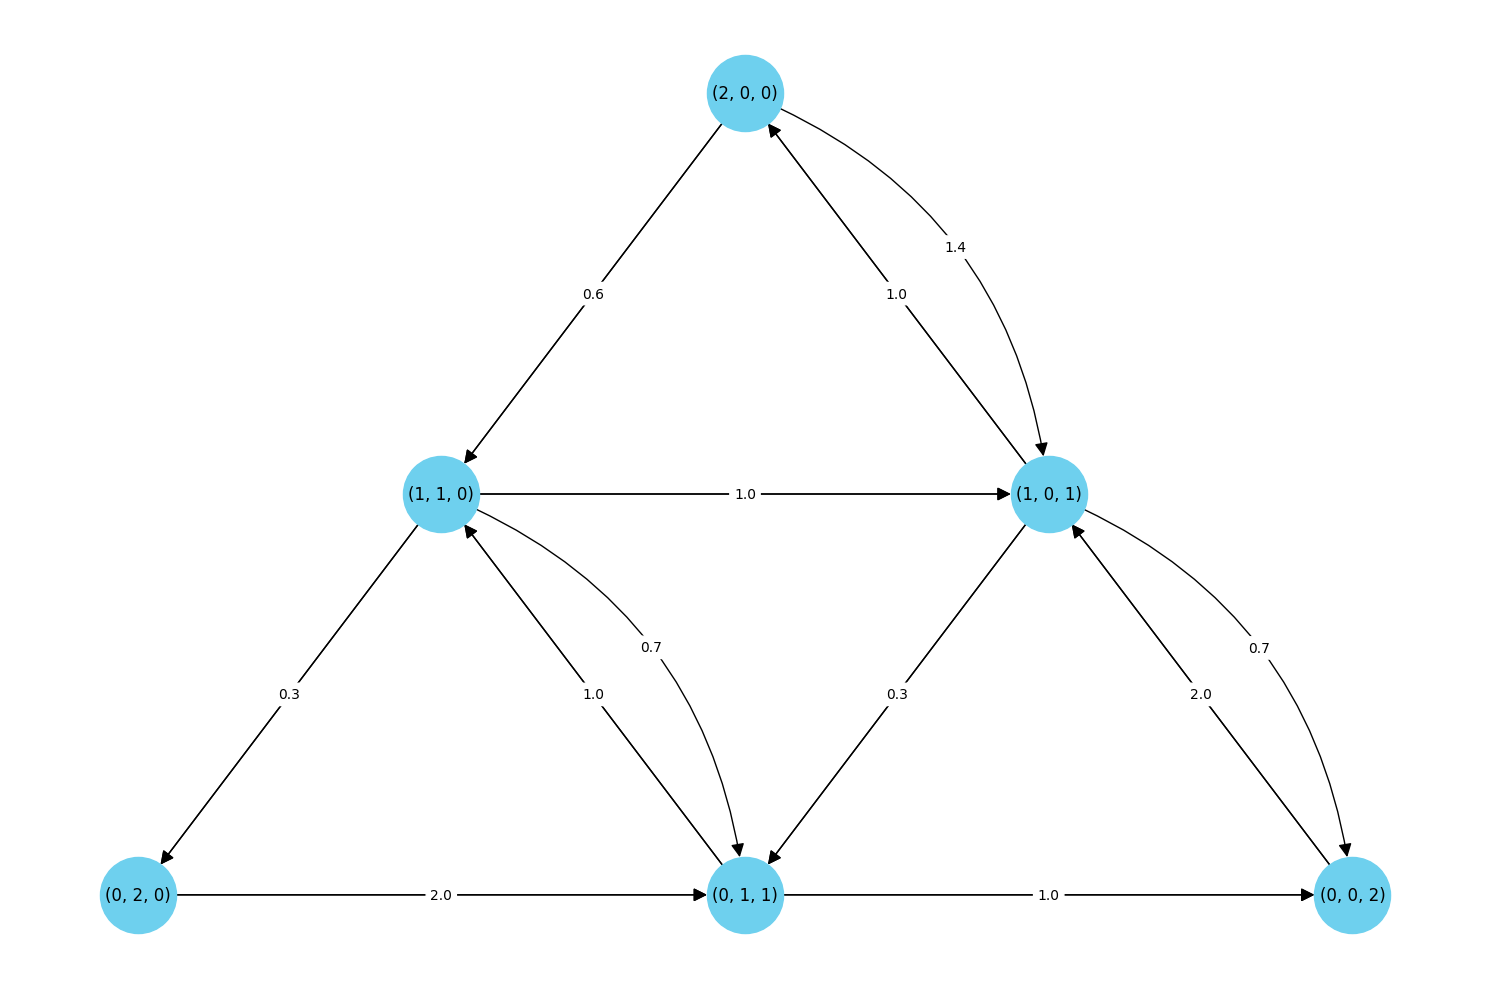

,Estado,Probabilidade
0,"(2, 0, 0)",0.1890
1,"(1, 1, 0)",0.1134
2,"(1, 0, 1)",0.3781
3,"(0, 2, 0)",0.0170
4,"(0, 1, 1)",0.1134
5,"(0, 0, 2)",0.1890


,U_i,Value
0,Esteira,0.6805
1,Bicicleta,0.1304
2,Elíptico,0.6805


,X_i,Value
0,Esteira,0.2268
1,Bicicleta,0.0435
2,Elíptico,0.2268


,X_0 (usuários/hora),R (minutos),V_esteira
0,4.5360,26.4550,3.0


In [ ]:
N = 2
K = 3

service_times = [3, 3, 3] # tempo em minutos
resources = {
    "Esteira": 0,
    "Bicicleta": 1,
    "Elíptico": 2
}
V_eliptico = 3

multiprog_level = {
    "Bicicleta": 2,
}

# Define the transition probabilities for the gym equipment based on the exercise
transition_probs = {
    (resources["Esteira"], resources["Bicicleta"]): .3,
    (resources["Esteira"], resources["Elíptico"]): .7,
    (resources["Bicicleta"], resources["Elíptico"]): 1,
    (resources["Elíptico"], resources["Esteira"]): 1
}

states = generate_states(N, K)
edges = generate_edges(N, service_times, states, transition_probs)
A, b = generate_system(states, edges)

draw_network_graph(K, N, states, edges, '15estados')
probabilities = solveSystem(A, b, states)

U_dict, X_dict = calculate_metrics2(K, probabilities, service_times, resources, multiprog_level=multiprog_level, factor=1)

X_0 = X_dict['Elíptico'] / V_eliptico
R = N / X_0

V_esteira = X_dict['Esteira'] / X_0

results = {
    "X_0 (usuários/hora)": f"{(X_0 * 60):.4f}",
    "R (minutos)": f"{R:.4f}",
    "V_esteira": V_esteira
}

# Display the results
display(pd.DataFrame(list(U_dict.items()), columns=['U_i', 'Value']))
display(pd.DataFrame(list(X_dict.items()), columns=['X_i', 'Value']))
display(pd.DataFrame([results]))


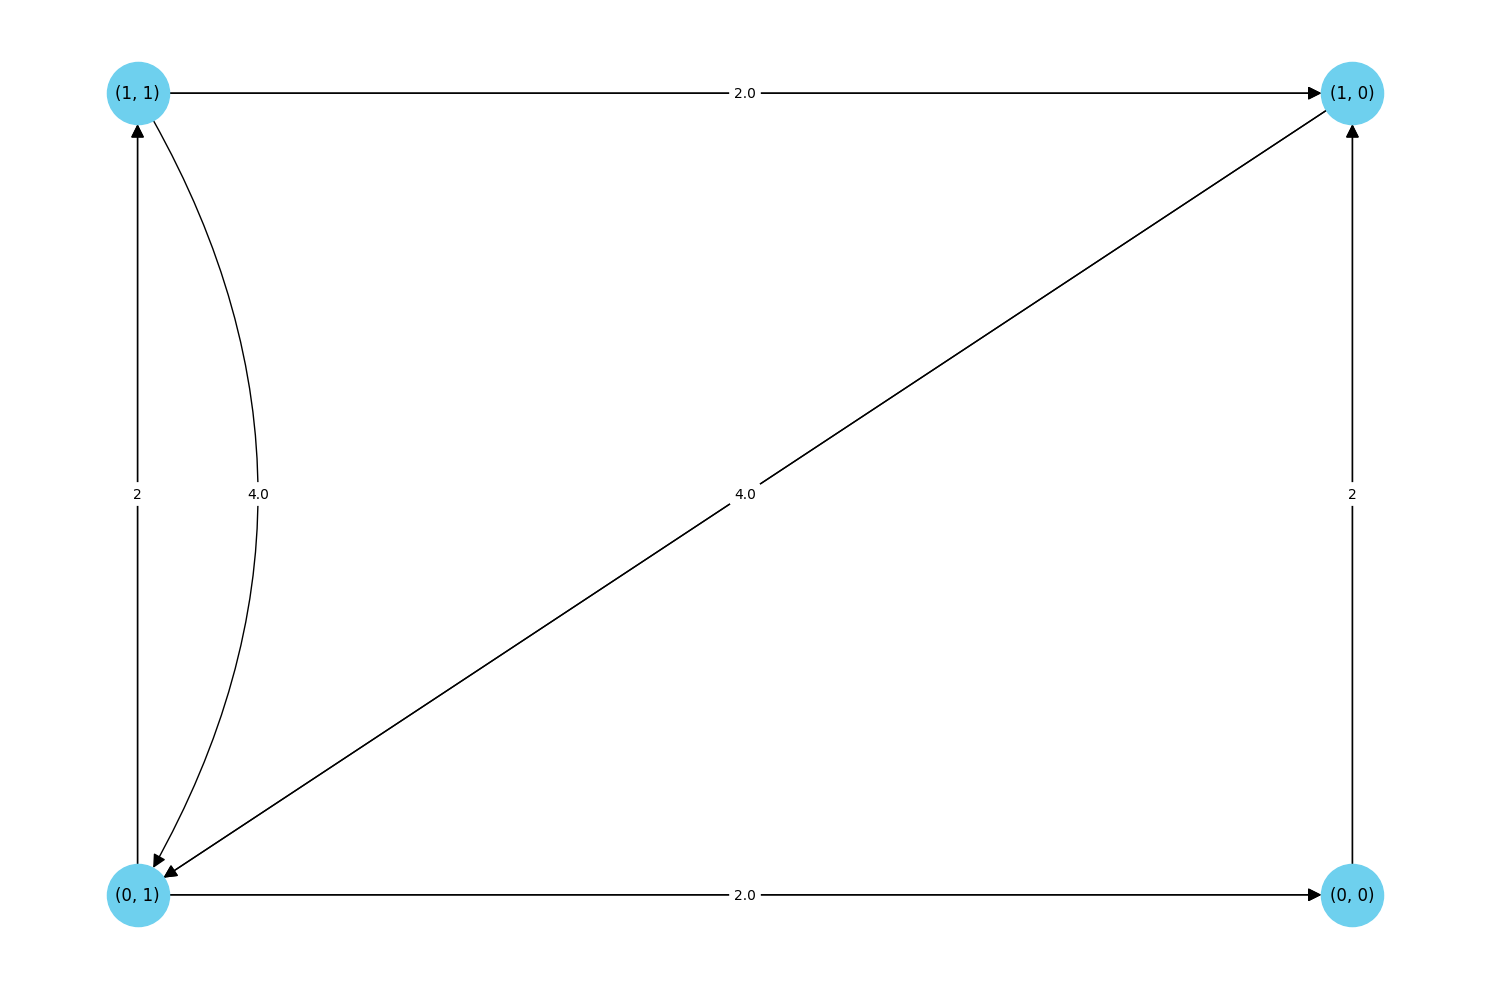

,Estado,Probabilidade
0,"(0, 0)",0.3333
1,"(1, 0)",0.2222
2,"(1, 1)",0.1111
3,"(0, 1)",0.3333


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
K = 2
N = 2
lambda_system = 2
service_times = [1/4, 1/2]

resources = {
    "Servidor A": {
        'min_users': 0,
        'max_users': 1,
        'index': 0,
    },
    "Servidor B": {
        'min_users': 0,
        'max_users': 1,
        'index': 1,
    },
}

resources_index = {index: resource for index, resource in enumerate(resources)}

states = [(0,0), (1,0), (1,1), (0,1)]

initial_state = {
    'state': (0,0),
    'index': -1
}

transition_probs = {
    (None, resources["Servidor A"]['index']): 1,
    (resources["Servidor A"]['index'], resources["Servidor B"]['index']): 1, 
    (resources["Servidor B"]['index'], None): 1,   
}

edges = generate_edges3(states, service_times, lambda_system, transition_probs, resources)

A, b = generate_system(states, edges)

draw_network_graph(K, N, states, edges, '3estados')
probabilities = solveSystem(A, b, states)

U_dict, X_dict, N_avg, X_0, R = calculate_metrics3(K, edges, probabilities, service_times, resources, factor=1, lambda_system=lambda_system)

results = {
    "N": N_avg,
    "X_0 (trans/min)": X_0,
    "R (segundos    )": R_seconds,
}

display(pd.DataFrame(list(U_dict.items()), columns=['U_i', 'Value']))
display(pd.DataFrame(list(X_dict.items()), columns=['X_i', 'Value']))
display(pd.DataFrame(list(results.items()), columns=['Metric', 'Value']))

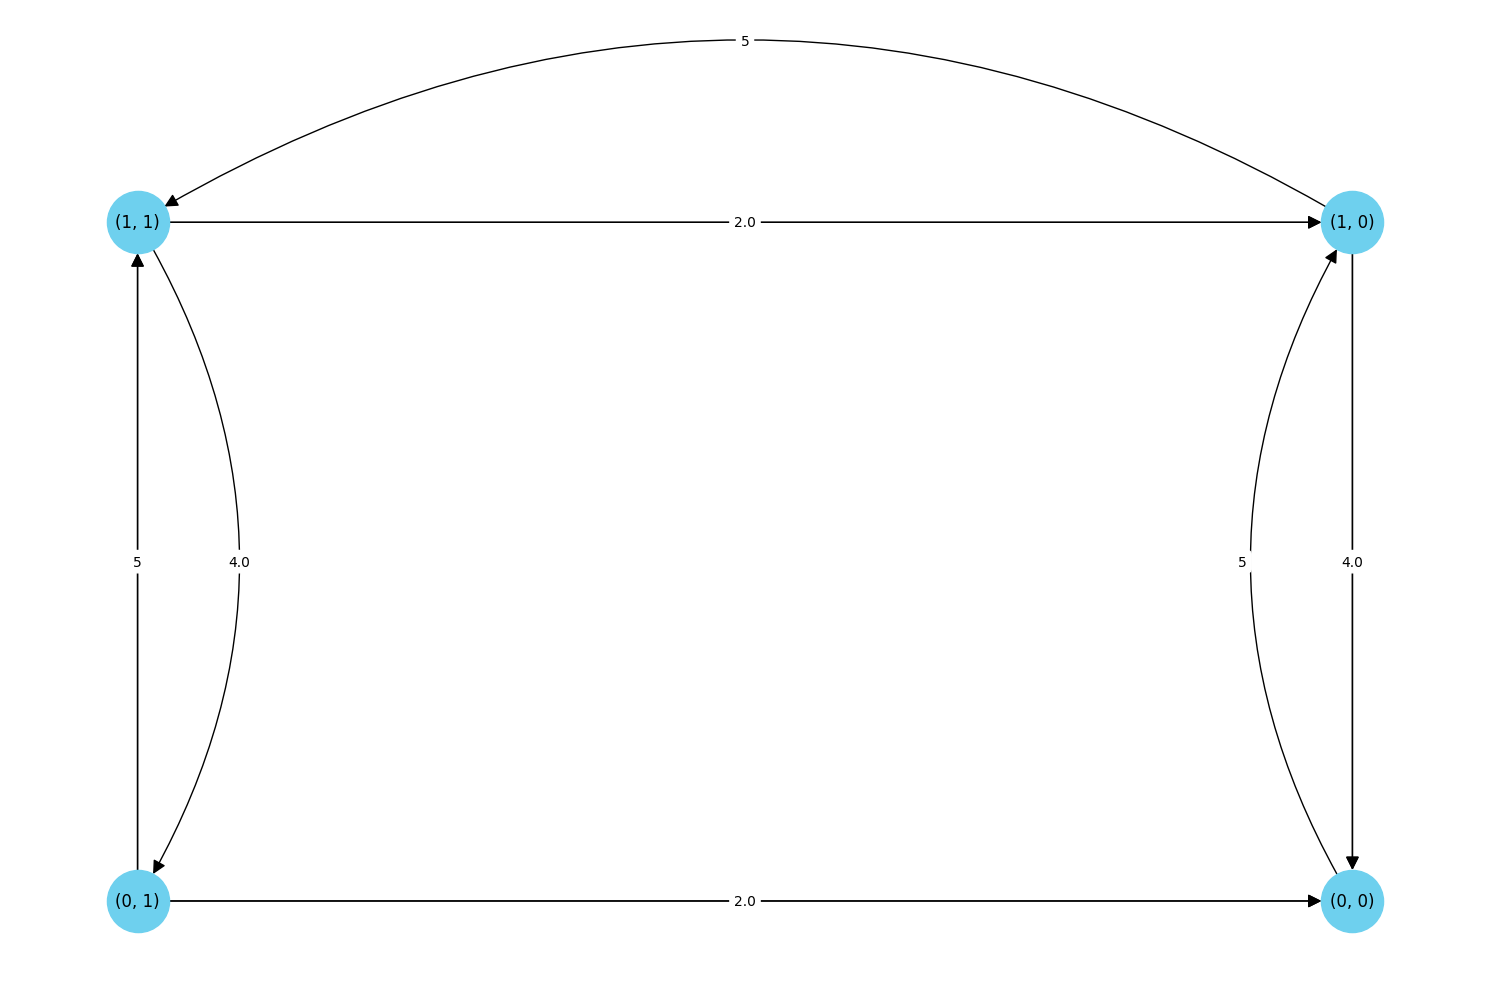

,Estado,Probabilidade
0,"(0, 0)",0.2495
1,"(1, 0)",0.2144
2,"(1, 1)",0.3411
3,"(0, 1)",0.1949


TypeError: calculate_metrics3() got an unexpected keyword argument 'lambda_system'

In [ ]:
K = 2
N = 2
lambda_system = 5
service_times = [1/4, 1/2]

resources = {
    "Servidor A": {
        'min_users': 0,
        'max_users': 1,
        'index': 0,
    },
    "Servidor B": {
        'min_users': 0,
        'max_users': 1,
        'index': 1,
    },
}

resources_index = {index: resource for index, resource in enumerate(resources)}

states = [(0,0), (1,0), (1,1), (0,1)]

transition_probs = {
    (None, resources["Servidor A"]['index']): 1,
    (None, resources["Servidor B"]['index']): 1,
    (resources["Servidor A"]['index'], None): 1, 
    (resources["Servidor B"]['index'], None): 1,
}

transition_origins = {
    (None, resources["Servidor B"]['index']): (1, 0),
}

edges = generate_edges3(states, service_times, lambda_system, transition_probs, resources, transition_origins = transition_origins)
A, b = generate_system(states, edges)

draw_network_graph(K, N, states, edges, '3estados')
probabilities = solveSystem(A, b, states)

U_dict, X_dict, N_avg, X_0, R = calculate_metrics3(K, edges, probabilities, service_times, resources, factor=1, lambda_system=lambda_system)

results = {
    "N": N_avg,
    "X_0 (trans/min)": X_0,
    "R (segundos    )": R_seconds,
}

display(pd.DataFrame(list(U_dict.items()), columns=['U_i', 'Value']))
display(pd.DataFrame(list(X_dict.items()), columns=['X_i', 'Value']))
display(pd.DataFrame(list(results.items()), columns=['Metric', 'Value']))



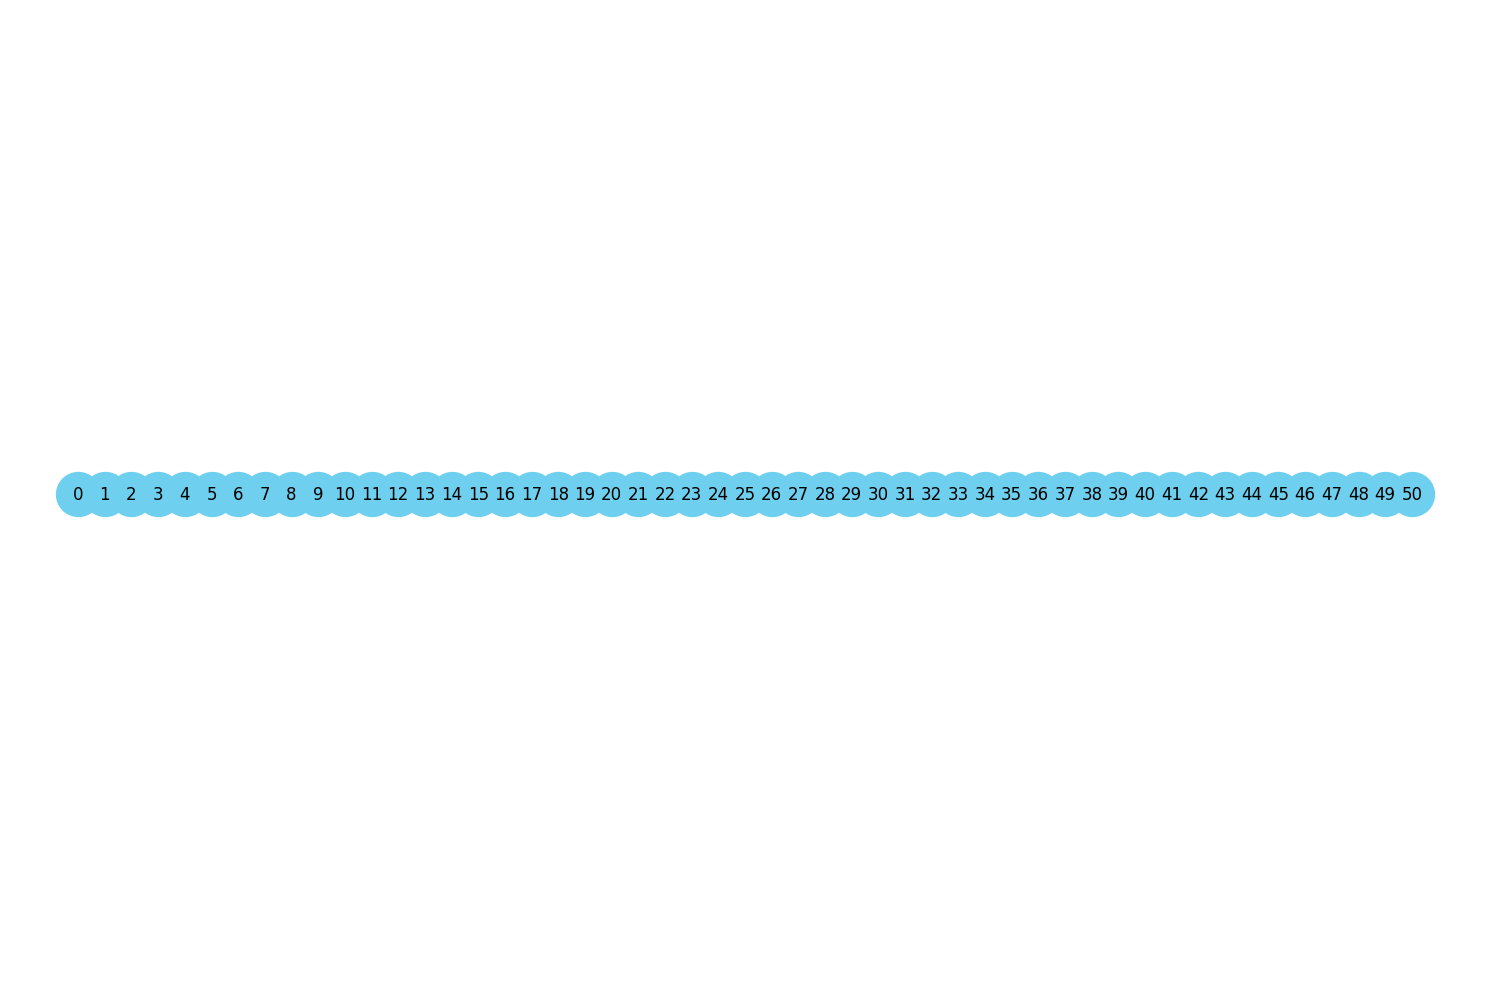

In [ ]:
M = 50
lambdaValue = 'λ'
custom_lambdas = []
lambdas = [ lambdaValue if lambdaValue != None else custom_lambdas[i] for i in range(0, M)]
muValue = 'μ'
custom_mus = []
mus = [ muValue if muValue != None else custom_mus[i] for i in range(0, M)]

states = generate_states_birthdeath(M)
edges = generate_edges_birthdeath(states, lambdas, mus)

# Convert edge list to index based
# A, b = generate_system(states, edges)

draw_network_graph_birthdeath(M, states, edges, 'birthdeathmodel')
# probabilities = solveSystem(A, b, states)

# U_dict, X_0, R_seconds = calculate_metrics(N, K, probabilities, service_times, custom_labels)

# results = {
#     "X_0 (trans/min)": X_0,
#     "R (segundos    )": R_seconds,
#     **U_dict
# }

# Display the results